# Heterogeneous Transfer Learning for Highly non-linear regression tasks: with knowledge of the target ODE structure

This notebook presents the code and results for executing $\text{HBTL}$ and its competitors $\mathrm{MHwG}$, $\mathrm{MHwG}_\mathrm{init}$, $\mathrm{L\text{-}BFGS\text{-}B}$, and $\mathrm{L\text{-}BFGS\text{-}B}_\mathrm{init}$ on both simulated and real data sets. The same training strategy for $\text{HBTL}$ is used for the competitors. Although we provide the code for executing the different combinations (different hyperparameters, training sizes, folds, and so on), executing them on a standard computer is computationally prohibitive. Our solution (as mentioned in the paper) was using our Linux server and launching different jobs in parallel, each containing one combination (since the different combinations are independent). However, due to job submission limitations, even this solution took us a long time. The final results (in csv format, which contain prediction errors and the min-max intervals) are saved and provided for visualization → see the folder Final_results_csv_files.

In [ ]:
import pandas as pd
import os, sys
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import glob

# Get the current working directory (where the notebook is)
current_dir = os.getcwd()

# Add the parent directory to sys.path (where hck_tools and python_files are)
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

from python_files.Plot_functions import *
from python_files.MCMC_LBFGSB_functions import * # This file "MCMC_functions" contain the functions used to perform our Bayesian inference 
                                          # (source and target modelling) and the same functions can be used to fit the MhWG and
                                          # the full fine-tuning version MhwG_init
from python_files.utils import * 

f_N_source = lambda data, params: output_data(data, params, nte=False, N=True)  # Returns simulated nitrogen output by solving the source ODE (fossil feeds)
f_N_target = lambda data, params: output_data(data, params, nte=True, N=True)  # Returns simulated nitrogen output by solving the target ODE (NTE feeds with Tire)

# Example of parameters bounds used to contraint the parameters space (HBTL, L-BFGS-B, etc.) -> The one used in the papers results are not provided for confidentiality
params_bounds_source = [(0, 1e3), (10000, 80000), (0.3, 10), (0.3, 10), (-10, 0), 
          (-40000, 0), (0, 10), (-5, 5), (0, 3), (-10, 10), (-10, 10)]

params_bounds_target = [(0, 1e3), (10000, 80000), (0.3, 10), (0.3, 10), (-10, 0), 
          (-40000, 0), (0, 10), (-5, 5), (0, 3), (-10, 10), (-10, 10), (0, 10)]

# Source modelling (estimation of source parameters and covariance matrix)

In [7]:
# Extract min and max values from bounds
min_values_source = np.array([b[0] for b in params_bounds_source])
max_values_source = np.array([b[1] for b in params_bounds_source])

# Generate three different initializations for source modeling from uniform distribution
sample1 = np.random.RandomState(seed=0).uniform(min_values_source, max_values_source)
sample2 = np.random.RandomState(seed=1).uniform(min_values_source, max_values_source)
sample3 = np.random.RandomState(seed=2).uniform(min_values_source, max_values_source)

list_params_init = [list(sample1), list(sample2), list(sample3)]

## Importing the source simulated data sets and selecting the training set 

In [ ]:
source_sim = pd.read_csv("Simulated_datasets/source_10000.csv", index_col=0)

Source_sim_train, Source_sim_val, train_idx, val_idx = kennard_stone_split_df( # the validation serve to select the best initialization
    source_sim, 
    feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP"], # Features columns -> used to calculate the distances within KS algorithm
    test_size=len(source_sim)-150 # Only 150 points are chosen to perform the MHwG, as using more would be computationally prohibitive
)

Calculating pairwise distances using scikit-learn.
Calculating pairwise distances using scikit-learn.


The following code shows how to run the $\text{MHwG}$ class on the source simulated data set with three different initializations, and with a weakly informative prior. The parameters are already saved. If you run the following code, it will overwrite them, and you will need to wait until the 20,000 iterations finish for each initialization to obtain new parameter estimates for inference.

In [ ]:
################################################################## launching MHwG on the source training set with the 3 initializations ################################################################
path_save_orig = "Results_simulated_data/source_params_estim/" # Path to save the results (the markov chains parameters)
iteration = 20000 # Number of iterations
for i in range(3): # launch three source MHwG with different initialization
    path_save = path_save_orig + f"init_{i}/" # New path for each intialization 
    os.makedirs(path_save, exist_ok=True) # Creating the subfolder for each intialization
    params_init = list_params_init[i] # The i-th random initialziation defined previously 
    params_init_df = params_transform(params_init, nte=False, bounds=params_bounds_source)
    run_bayesian_method_unified(
        method='MHwG_source', 
        iteration=iteration,
        fold_dir=path_save,
        base_index=i,
        train_size=None,
        df_train=Source_sim_train,
        params_init=params_init_df,
        f_model=f_N_source,
        f_hard=f_hard,
        f_var=f_var,
        f_likelyhood=f_likelyhood,
        target_column="N_simul"
    )

In [ ]:
# Select the best source parameters estimation among the three initializations
y_train = Source_sim_train["N_simul"] # N_simul is the real output nitrogen within the simulated data set (simul refer to simulated)
y_val = Source_sim_val["N_simul"]

path_save_orig = "Results_simulated_data/source_params_estim/"
best_loss = np.inf
best_init = None
best_params = None

for i in range(3):
    path_save = path_save_orig + f"init_{i}/param_estim_MCMC_source_20000it.csv"
    params_source = pd.read_csv(path_save, index_col=0)
    params_source = params_source.drop(params_source.columns[0], axis=1)# remove the first column (number of row)
    params_source = params_source.iloc[19000:,:] # Taking the last 1000 iteration for the inference
    params_source = params_source.drop(params_source.columns[11], axis=1) # remove the sigma column since not needed here for the calculation of the predictions error
    params_mean = list(params_source.mean()) # Compute the estimated source parameters (the mean of the last 1000 iterations)
    params_source_iter = params_transform(params_mean, nte=False) # Transform the parameters to the frame format 

    y_pred_val = output_data(Source_sim_val, params_source_iter, nte=False, N=True) # Compute the output nitrogen predictions
    val_loss = np.mean((y_val-y_pred_val)**2/y_val) # calculate the validation loss
        
    # Track best initialization
    if val_loss < best_loss:
        best_loss = val_loss
        best_init = i
        best_params = params_mean

print("\n" + "="*50)
print(f"Best initialization: {best_init}")
print("="*50)


Best initialization: 2


In [ ]:
# Taking the best initializaiton to initialize HBTL and MHwG_init later
path_source_params_sim = "Results_simulated_data/source_params_estim/init_2/param_estim_MCMC_source_20000it.csv" # path to the best source 
                                                                                                                         #initialization 

source_params_sim = pd.read_csv(path_source_params_sim, index_col=0)
source_params_sim = source_params_sim.drop(source_params_sim.columns[0], axis=1)
source_params_sim = source_params_sim.iloc[19000:,:]
sigma_value_sim = source_params_sim["sigma"].mean() # This value is used to initialize the sigma within HBTL and MHwG: for HBTL we makfixe sigma_target=sigma_value_sim
source_params_sim = source_params_sim.drop(source_params_sim.columns[11], axis=1) # remove the sigma column now, no need anymore
params_init_sim = list(source_params_sim.mean()) # The initialization for the common parameters used in HBTL and MHwG_init
params_init_sim = params_init_sim + [0.001] # p is intialized with 0.001 or can be initialized with any number within its interval. 
params_target_init_sim = params_transform(params=params_init_sim, nte=True, bounds=params_bounds_target)

## Real data sets

In [ ]:
source_real = pd.read_csv("Real_datasets/source_vgo.csv", index_col=0)
Source_real_train, Source_real_val, train_idx, val_idx = kennard_stone_split_df( # the validation serve to select the best initialization
    source_real, 
    feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP"], 
    test_size=len(source_real)-110 # 110 points are used for training, and the rest for validation
)

Calculating pairwise distances using scikit-learn.
Calculating pairwise distances using scikit-learn.


Same, the parameters are already saved. If you run this code, it will overwrite them, and you will need to wait until the 20,000 iterations finish to obtain new parameter estimates for inference.

In [ ]:
################################################################## launching MHwG with the 3 initializations ################################################################
path_save_orig = "Results_real_data/source_params_estim/" # Real source data set
iteration = 20000
for i in range(3): 
    path_save = path_save_orig + f"init_{i}/"
    os.makedirs(path_save, exist_ok=True)
    params_init = list_params_init[i]
    params_init_df = params_transform(params_init, nte=False, bounds=params_bounds_source)
    run_bayesian_method_unified(
        method='MHwG_source',
        iteration=iteration,
        fold_dir=path_save,
        base_index=i,
        train_size=None,
        df_train=Source_real_train,
        params_init=params_init_df,
        f_model=f_N_source,
        f_hard=f_hard,
        f_var=f_var,
        f_likelyhood=f_likelyhood,
        target_column="Azote_liqTot"
    )

In [ ]:
y_train = Source_real_train["Azote_liqTot"] # Azote_liqTot is the real output nitrogen in the real data set 
y_val = Source_real_val["Azote_liqTot"]

path_save_orig = "Results_real_data/source_params_estim/"
best_loss = np.inf
best_init = None
best_params = None

for i in range(3):
    path_save = path_save_orig + f"init_{i}/param_estim_MCMC_source_20000it.csv"
    params_source = pd.read_csv(path_save, index_col=0)
    params_source = params_source.drop(params_source.columns[0], axis=1)
    params_source = params_source.iloc[19000:,:]
    params_source = params_source.drop(params_source.columns[11], axis=1)
    params_mean = list(params_source.mean())
    params_source_iter = params_transform(params_mean, nte=False)

    y_pred_val = output_data(Source_real_val, params_source_iter, nte=False, N=True)
    val_loss = np.mean((y_val-y_pred_val)**2/y_val) 
        
    if val_loss < best_loss:
        best_loss = val_loss
        best_init = i
        best_params = params_mean

print("\n" + "="*50)
print(f"Best initialization: {best_init}")
print("="*50)

In [ ]:
path_source_params_real = "Results_real_data/source_params_estim/init_1/param_estim_MCMC_source_20000it.csv" # path to the best source initialization 

source_params_real = pd.read_csv(path_source_params_real, index_col=0)
source_params_real = source_params_real.drop(source_params_real.columns[0], axis=1)
source_params_real = source_params_real.iloc[19000:,:]
sigma_value_real = source_params_real["sigma"].mean()
source_params_real = source_params_real.drop(source_params_real.columns[11], axis=1) # remove the sigma column now, no need anymore
params_init_real = list(source_params_real.mean()) # The initialization for the common parameters used in HBTL and MHwG_init
params_init_real = params_init_real + [0.001] # p is intialized with 0.001 or can be initialized with any number within its interval. 
params_target_init_real = params_transform(params=params_init_real, nte=True, bounds=params_bounds_target)    

# Target real data set

In [7]:
target_real = pd.read_csv("Real_datasets/pilot_pivot_co.csv" )# reading the corresponding real data set
target_real = target_real.drop(target_real.columns[0], axis=1)

# HBTL (target modelling -> estimation of the target parameters using an informative prior)

## Simulated target data sets

In [ ]:
base_path_HBTL_sim = 'Results_simulated_data/HBTL' 
iteration = 20000

# The different hyperparameter used
gs = [1, 10, 100, 1000, 10000]

for base in range(20):
    base_dir = os.path.join(base_path_HBTL_sim, f'base_{base}') # The folder for each data set
    path_target_data = f"Simulated_datasets/Target_data_sets/target_base{base}.csv" # reading the corresponding simulated data set
    target_sim_iter = pd.read_csv(path_target_data)
    target_sim_iter = target_sim_iter.drop(target_sim_iter.columns[0], axis=1)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        Target_sim_train_iter, Target_sim_test_iter, train_idx, val_idx = kennard_stone_split_df( # For simulated data sets, the train is selected 
            target_sim_iter,                                                                           # with KS algorithm
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_sim_iter)-train
        )

        for g in gs:
            g_dir = os.path.join(train_dir, f'g={g}')
            # Cross-validation
            fold_size = size_fold(train)
            k_folds = int(len(Target_sim_train_iter)/fold_size)
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_sim_train_iter)):
                fold_dir = os.path.join(g_dir, f'fold={fold_idx}')
                os.makedirs(fold_dir, exist_ok=True)
                
                # Get fold data
                df_train_target = Target_sim_train_iter.iloc[train_idx].reset_index(drop=True)
                df_val_target = Target_sim_train_iter.iloc[val_idx].reset_index(drop=True)

                run_bayesian_method_unified(
                    method='HBTL',
                    iteration=iteration,
                    fold_dir=fold_dir,
                    base_index=base,
                    train_size=train,
                    fold_idx=fold_idx,
                    df_train=df_train_target,
                    df_val=df_val_target,
                    df_test=Target_sim_test_iter,
                    params_init=params_target_init_sim,
                    sigma_value=sigma_value_sim,
                    g=g,
                    params_prior=source_params_sim,
                    f_model=f_N_target,
                    f_hard=f_hard,
                    f_var=f_var,
                    f_likelyhood=f_likelyhood,
                    target_column="N_simul",
                    index_name="base_index"
                )


# Once all different combination results are obtained, now we concatenate 
# all the frame_results into one data frame so we can easily extract the best 
# hyperparameters, calculating the mean test score and the associated min-max intervals

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_HBTL_sim, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_hbtl_sim = consolidated_df_sim.groupby(["base_index","train_size", "g"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Selection of the best initialization
best_params_per_base_train_size_hbtl_sim = fold_means_hbtl_sim.loc[
    fold_means_hbtl_sim.groupby(["base_index", "train_size"])["val_loss"].idxmin()
].reset_index(drop=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_hbtl_sim = best_params_per_base_train_size_hbtl_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'HBTL_sim_consolidated.csv') 
mean_scores_hbtl_sim.to_csv(output_file, index=False)
print("Done!")

## Real target data set

In [ ]:
seed_path_HBTL_real = 'Results_real_data/HBTL' 
iteration = 20000

# The different g used
gs = [1, 10, 100, 1000, 10000]

for seed in range(20):
    seed_dir = os.path.join(seed_path_HBTL_real, f'seed_{seed}') # The folder for each data set
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        Target_real_train_iter, Target_real_test_iter = train_test_split( # For the real data set, the train is selected randomly each time using the seed
            target_real,                                                                  
            test_size=len(target_real)-train,
            random_state=seed
        )
        Target_real_train_iter = Target_real_train_iter.reset_index(drop=True)
        Target_real_test_iter = Target_real_test_iter.reset_index(drop=True)
        for g in gs:
            g_dir = os.path.join(train_dir, f'g={g}')
            # Cross-validation
            fold_size = size_fold(train)
            k_folds = int(len(Target_real_train_iter)/fold_size)
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_real_train_iter)):
                fold_dir = os.path.join(g_dir, f'fold={fold_idx}')
                os.makedirs(fold_dir, exist_ok=True)
                
                # Get fold data
                df_train_target = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
                df_val_target = Target_real_train_iter.iloc[val_idx].reset_index(drop=True)

                run_bayesian_method_unified(
                    method='HBTL',
                    iteration=iteration,
                    fold_dir=fold_dir,
                    base_index=base,
                    train_size=train,
                    fold_idx=fold_idx,
                    df_train=df_train_target,
                    df_val=df_val_target,
                    df_test=Target_real_test_iter,
                    params_init=params_target_init_real,
                    sigma_value=sigma_value_real,
                    g=g,
                    params_prior=source_params_real,
                    f_model=f_N_target,
                    f_hard=f_hard,
                    f_var=f_var,
                    f_likelyhood=f_likelyhood,
                    target_column="Azote_liqTot",
                    index_name="seed_index"
                )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_HBTL_real, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)
# Average loss across folds
fold_means_hbtl_real = consolidated_df_real.groupby(["base_index","train_size", "g"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Selection of the best initialization
best_params_per_base_train_size_hbtl_real = fold_means_hbtl_real.loc[
    fold_means_hbtl_real.groupby(["seed_index", "train_size"])["val_loss"].idxmin()
].reset_index(drop=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_hbtl_real = best_params_per_base_train_size_hbtl_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'HBTL_real_consolidated.csv') 
mean_scores_hbtl_real.to_csv(output_file, index=False)
print("Done!")

# Competitors of HBTL

## Simulated data sets

### MHwG

In [ ]:
params_init_mhwg = list(sample1) + [0.001]
params_mhwg_init_sim = params_transform(params_init_mhwg, nte=True) 

base_path_MHwG_sim = 'Results_simulated_data/MHwG' 
iteration = 20000                                                                                               
for base in range(20):
    base_dir = os.path.join(base_path_MHwG_sim, f'base_{base}') 
    path_target_data = f"Simulated_datasets/Target_data_sets/target_base{base}.csv" 
    target_sim_iter = pd.read_csv(path_target_data)
    target_sim_iter = target_sim_iter.drop(target_sim_iter.columns[0], axis=1)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        Target_sim_train_iter, Target_sim_test_iter, train_idx, val_idx = kennard_stone_split_df( 
            target_sim_iter,                                                                           
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_sim_iter)-train
        )

        # Cross-validation
        fold_size = size_fold(train)
        k_folds = int(len(Target_sim_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_sim_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            os.makedirs(fold_dir, exist_ok=True)
            
            # Get fold data
            df_train_target = Target_sim_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_sim_train_iter.iloc[val_idx].reset_index(drop=True)

            run_bayesian_method_unified(
                method='MHwG',
                iteration=iteration,
                fold_dir=fold_dir,
                base_index=base,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_sim_test_iter,
                params_init=params_mhwg_init_sim,
                f_model=f_N_target,
                f_hard=f_hard,
                f_var=f_var,
                f_likelyhood=f_likelyhood,
                target_column="N_simul",
                index_name="base_index"
            )
# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_MHwG_sim, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_mhwg_sim = consolidated_df_sim.groupby(["base_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mhwg_sim = fold_means_mhwg_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MHwG_sim_consolidated.csv') 
mean_scores_mhwg_sim.to_csv(output_file, index=False)
print("Done!")

$\mathrm{MHwG}_\mathrm{init}$

In [ ]:
base_path_MHwG_init_sim = 'Results_simulated_data/MHwG_init' 
iteration = 20000                                                                                                
for base in range(20):
    base_dir = os.path.join(base_path_MHwG_init_sim, f'base_{base}') # The folder for each data set
    path_target_data = f"Simulated_datasets/Target_data_sets/target_base{base}.csv" # reading the corresponding simulated data set 
    target_sim_iter = pd.read_csv(path_target_data)
    target_sim_iter = target_sim_iter.drop(target_sim_iter.columns[0], axis=1)
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        Target_sim_train_iter, Target_sim_test_iter, train_idx, val_idx = kennard_stone_split_df( 
            target_sim_iter,                                                                           
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_sim_iter)-train
        )

        y_test = Target_sim_test_iter["N_simul"]
        # Cross-validation
        fold_size = size_fold(train)
        k_folds = int(len(Target_sim_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_sim_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            os.makedirs(fold_dir, exist_ok=True)
            
            # Get fold data
            df_train_target = Target_sim_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_sim_train_iter.iloc[val_idx].reset_index(drop=True)

            run_bayesian_method_unified(
                method='MHwG_init',
                iteration=iteration,
                fold_dir=fold_dir,
                base_index=base,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_sim_test_iter,
                params_init=params_target_init_sim, 
                sigma_value=sigma_value_sim, 
                f_model=f_N_target,
                f_hard=f_hard,
                f_var=f_var,
                f_likelyhood=f_likelyhood,
                target_column="N_simul",
                index_name="base_index"
            )


# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_MHwG_init_sim, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_mhwg_init_sim = consolidated_df_sim.groupby(["base_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mhwg_init_sim = fold_means_mhwg_init_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MHwG_init_sim_consolidated.csv') 
mean_scores_mhwg_init_sim.to_csv(output_file, index=False)
print("Done!")

### L-BFGS-B

In [ ]:
# Generate 1000 random initializations
np.random.seed(0)
params_init_lbfgsb = []
for i in range(1000):
    init_values = [np.random.uniform(b[0], b[1]) for b in params_bounds_target]
    params_init_lbfgsb.append(init_values)

base_path_LBFGSB_sim = 'Results_simulated_data/LBFGSB'
for base in range(20):
    base_dir = os.path.join(base_path_LBFGSB_sim, f'base_{base}')
    path_target_data = f"Simulated_datasets/Target_data_sets/target_base{base}.csv"
    target_sim_iter = pd.read_csv(path_target_data)
    target_sim_iter = target_sim_iter.drop(target_sim_iter.columns[0], axis=1)
    
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        Target_sim_train_iter, Target_sim_test_iter, train_idx, val_idx = kennard_stone_split_df(
            target_sim_iter,
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_sim_iter)-train
        )
        
        fold_size = size_fold(train)
        k_folds = int(len(Target_sim_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_sim_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            df_train_target = Target_sim_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_sim_train_iter.iloc[val_idx].reset_index(drop=True)
            
            run_lbfgsb_method(
                method='LBFGSB',
                fold_dir=fold_dir,
                base_index=base,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_sim_test_iter,
                params_init=params_init_lbfgsb,
                bounds=params_bounds_target,
                target_column="N_simul",
                index_name="base_index"
            )


# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_LBFGSB_sim, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_lbfgsb_sim = consolidated_df_sim.groupby(["params_init_index","base_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Selection of the best initialization
best_init_per_base_train_size_lbfgs_sim = fold_means_lbfgsb_sim.loc[
    fold_means_lbfgsb_sim.groupby(["base_index", "train_size"])["val_loss"].idxmin()
].reset_index(drop=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_lbfgsb_sim = best_init_per_base_train_size_lbfgs_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'LBFGSB_sim_results.csv') 
mean_scores_lbfgsb_sim.to_csv(output_file, index=False)
print("Done!")

###  $\mathrm{L\text{-}BFGS\text{-}B}_{\mathrm{init}}$

In [ ]:
base_path_LBFGSB_init_sim = 'Results_simulated_data/LBFGSB_init'
for base in range(20):
    base_dir = os.path.join(base_path_LBFGSB_init_sim, f'base_{base}')
    path_target_data = f"Simulated_datasets/Target_data_sets/target_base{base}.csv"
    target_sim_iter = pd.read_csv(path_target_data)
    target_sim_iter = target_sim_iter.drop(target_sim_iter.columns[0], axis=1)
    
    for train in range(5, 105, 5):
        train_dir = os.path.join(base_dir, f'train={train}')
        Target_sim_train_iter, Target_sim_test_iter, train_idx, val_idx = kennard_stone_split_df(
            target_sim_iter,
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_sim_iter)-train
        )
        
        fold_size = size_fold(train)
        k_folds = int(len(Target_sim_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_sim_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            df_train_target = Target_sim_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_sim_train_iter.iloc[val_idx].reset_index(drop=True)
            
            run_lbfgsb_method(
                method='LBFGSB_init',
                fold_dir=fold_dir,
                base_index=base,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_sim_test_iter,
                params_init=params_init_sim,  # Single initialization (same as HBTL/MHwG_init)
                bounds=params_bounds_target,
                target_column="N_simul",
                index_name="base_index"
            )

# Find all CSV files
csv_files = glob.glob(os.path.join(base_path_LBFGSB_init_sim, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_sim = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_lbfgsb_init_sim = consolidated_df_sim.groupby(["params_init_index","base_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and data sets, with min-max intervals
mean_scores_lbfgsb_init_sim = fold_means_lbfgsb_init_sim.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'LBFGSB_init_sim_results.csv') 
mean_scores_lbfgsb_init_sim.to_csv(output_file, index=False)
print("Done!")

## Real data set

### MHwG

In [ ]:
params_init_mhwg = list(sample1) + [0.001]
params_mhwg_init_real = params_transform(params_init_mhwg, nte=True) 

seed_path_MHwG_real = 'Results_real_data/MHwG' 
iteration = 20000     

for seed in range(20):
    seed_dir = os.path.join(seed_path_MHwG_real, f'seed_{seed}') # The folder for each data set
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        Target_real_train_iter, Target_real_test_iter, train_idx, val_idx = train_test_split( 
            target_real,                                                                           
            test_size=len(target_real)-train,
            random_state=seed
        )

        Target_real_train_iter = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
        Target_real_test_iter = Target_real_test_iter.iloc[val_idx].reset_index(drop=True)

        y_test = Target_real_test_iter["Azote_liqTot"]
        # Cross-validation
        fold_size = size_fold(train)
        k_folds = int(len(Target_real_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_real_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            os.makedirs(fold_dir, exist_ok=True)
            
            # Get fold data
            df_train_target = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_real_train_iter.iloc[val_idx].reset_index(drop=True)

            run_bayesian_method_unified(
                method='MHwG',
                iteration=iteration,
                fold_dir=fold_dir,
                base_index=seed,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_real_test_iter,
                params_init=params_mhwg_init_real,
                f_model=f_N_target,
                f_hard=f_hard,
                f_var=f_var,
                f_likelyhood=f_likelyhood,
                target_column="Azote_liqTot",
                index_name="seed_index"
            )
# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_MHwG_real, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_mhwg_real = consolidated_df_real.groupby(["seed_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mhwg_real = fold_means_mhwg_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MHwG_real_consolidated.csv') 
mean_scores_mhwg_real.to_csv(output_file, index=False)
print("Done!")

$\mathrm{MHwG}_\mathrm{init}$

In [ ]:
seed_path_MHwG_init_real = 'Results_real_data/MHwG_init' 
iteration = 20000                                                                                                  
for seed in range(20):
    seed_dir = os.path.join(seed_path_MHwG_init_real, f'seed_{seed}') # The folder for each data set
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        Target_real_train_iter, Target_real_test_iter, train_idx, val_idx = train_test_split( 
            target_real,                                                                      
            feature_columns = ["T", "ppH2", "LHSV", "Res0", "N0", "S0", "TMP", "Tire"],
            test_size=len(target_real)-train,
            random_state=seed
        )

        Target_real_train_iter = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
        Target_real_test_iter = Target_real_test_iter.iloc[val_idx].reset_index(drop=True)
        y_test = Target_real_test_iter["Azote_liqTot"]
        # Cross-validation
        fold_size = size_fold(train)
        k_folds = int(len(Target_real_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_real_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            os.makedirs(fold_dir, exist_ok=True)
            
            # Get fold data
            df_train_target = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_real_train_iter.iloc[val_idx].reset_index(drop=True)

            run_bayesian_method_unified(
                method='MHwG_init',
                iteration=iteration,
                fold_dir=fold_dir,
                base_index=seed,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_real_test_iter,
                params_init=params_target_init_real,
                sigma_value=sigma_value_real,
                f_model=f_N_target,
                f_hard=f_hard,
                f_var=f_var,
                f_likelyhood=f_likelyhood,
                target_column="Azote_liqTot",
                index_name="seed_index"
            )


# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_MHwG_init_real, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_mhwg_init_real = consolidated_df_real.groupby(["seed_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_mhwg_init_real = fold_means_mhwg_init_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'MHwG_init_real_consolidated.csv') 
mean_scores_mhwg_init_real.to_csv(output_file, index=False)
print("Done!")

### $\mathrm{L\text{-}BFGS\text{-}B}$

In [ ]:
seed_path_LBFGSB_real = 'Results_real_data/LBFGSB'
for seed in range(20):
    seed_dir = os.path.join(seed_path_LBFGSB_real, f'seed_{seed}')
    
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        Target_real_train_iter, Target_real_test_iter = train_test_split(
            target_real,
            test_size=len(target_real)-train,
            random_state=seed
        )
        
        Target_real_train_iter = Target_real_train_iter.reset_index(drop=True)
        Target_real_test_iter = Target_real_test_iter.reset_index(drop=True)
        
        fold_size = size_fold(train)
        k_folds = int(len(Target_real_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_real_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            df_train_target = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_real_train_iter.iloc[val_idx].reset_index(drop=True)
            
            run_lbfgsb_method(
                method='LBFGSB',
                fold_dir=fold_dir,
                base_index=seed,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_real_test_iter,
                params_init=params_init_lbfgsb,
                bounds=params_bounds_target,
                loss_function=loss_function,
                target_column="Azote_liqTot",
                index_name="seed_index"
            )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_LBFGSB_real, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_lbfgsb_real = consolidated_df_real.groupby(["params_init_index","base_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Selection of the best initialization
best_init_per_base_train_size_lbfgs_real = fold_means_lbfgsb_real.loc[
    fold_means_lbfgsb_real.groupby(["seed_index", "train_size"])["val_loss"].idxmin()
].reset_index(drop=True)

# Calculate mean test scores across different training sizes and datasets, with min-max intervals
mean_scores_lbfgsb_real = best_init_per_base_train_size_lbfgs_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'LBFGSB_real_results.csv') 
mean_scores_lbfgsb_real.to_csv(output_file, index=False)
print("Done!")

###  $\mathrm{L\text{-}BFGS\text{-}B}_{\mathrm{init}}$

In [ ]:
seed_path_LBFGSB_init_real = 'Results_real_data/LBFGSB_init'
for seed in range(20):
    seed_dir = os.path.join(seed_path_LBFGSB_init_real, f'seed_{seed}')
    
    for train in range(5, 105, 5):
        train_dir = os.path.join(seed_dir, f'train={train}')
        Target_real_train_iter, Target_real_test_iter = train_test_split(
            target_real,
            test_size=len(target_real)-train,
            random_state=seed
        )
        
        Target_real_train_iter = Target_real_train_iter.reset_index(drop=True)
        Target_real_test_iter = Target_real_test_iter.reset_index(drop=True)
        
        fold_size = size_fold(train)
        k_folds = int(len(Target_real_train_iter)/fold_size)
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(Target_real_train_iter)):
            fold_dir = os.path.join(train_dir, f'fold={fold_idx}')
            df_train_target = Target_real_train_iter.iloc[train_idx].reset_index(drop=True)
            df_val_target = Target_real_train_iter.iloc[val_idx].reset_index(drop=True)
            
            run_lbfgsb_method(
                method='LBFGSB_init',
                fold_dir=fold_dir,
                base_index=seed,
                train_size=train,
                fold_idx=fold_idx,
                df_train=df_train_target,
                df_val=df_val_target,
                df_test=Target_real_test_iter,
                params_init=params_init_real,  # Single initialization (same as HBTL/MHwG_init)
                bounds=params_bounds_target,
                loss_function=loss_function,
                target_column="Azote_liqTot",
                index_name="seed_index"
            )

# Find all CSV files
csv_files = glob.glob(os.path.join(seed_path_LBFGSB_init_real, '**/frame_results.csv'), recursive=True)
print(f"Found {len(csv_files)} CSV files")

# Read and concatenate all CSV files
dfs_list = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    dfs_list.append(df)
consolidated_df_real = pd.concat(dfs_list, ignore_index=True)

# Average loss across folds
fold_means_lbfgsb_init_real = consolidated_df_real.groupby(["params_init_index","seed_index","train_size"]).agg(
    val_loss=("val_loss", "mean"),
    MAE_test=("MAE_test", "mean"),
).reset_index()

# Calculate mean test scores across different training sizes and data sets, with min-max intervals
mean_scores_lbfgsb_init_real = fold_means_lbfgsb_init_real.groupby(["train_size"]).agg(
    MAE_test=("MAE_test", "mean"),  
    lower_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 2.5)),
    upper_ci_mae_test=("MAE_test", lambda x: np.percentile(x, 97.5)),
).reset_index()

output_file = os.path.join('Final_results_csv_files', 'LBFGSB_init_real_results.csv') 
mean_scores_lbfgsb_init_real.to_csv(output_file, index=False)
print("Done!")

# Results

## Simulated data sets

In [47]:
##################################################################### HBTL and its competitors ####################################################################################
HBTL_sim_results = pd.read_csv("Final_results_csv_files/HBTL_sim_results.csv")
MHwG_sim_results = pd.read_csv("Final_results_csv_files/MHwG_sim_results.csv")
MHwG_init_sim_results = pd.read_csv("Final_results_csv_files/MHwG_init_sim_results.csv")
LBFGSB_sim_results = pd.read_csv("Final_results_csv_files/LBFGSB_sim_results.csv")
LBFGSB_init_sim_results = pd.read_csv("Final_results_csv_files/LBFGSB_init_sim_results.csv")

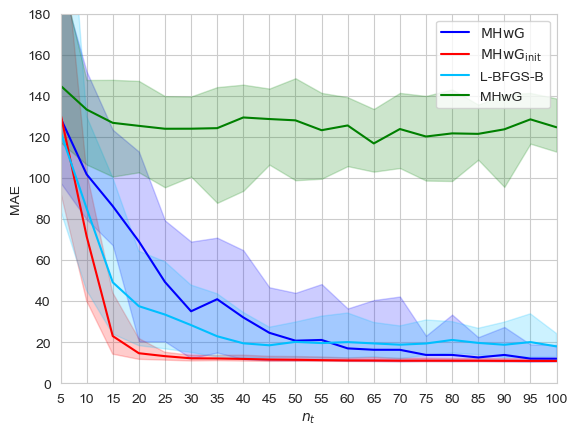

In [45]:
##################################################################### Competitors ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=MHwG_sim_results["train_size"], y=MHwG_sim_results["MAE_test"], color="blue", label="$\mathrm{MHwG}$")
sns.lineplot(x=MHwG_init_sim_results["train_size"], y=MHwG_init_sim_results["MAE_test"], color="red", label="$\mathrm{MHwG}_\mathrm{init}$")
sns.lineplot(x=LBFGSB_sim_results["train_size"], y=LBFGSB_sim_results["MAE_test"], color="deepskyblue", label="L-BFGS-B")
sns.lineplot(x=LBFGSB_init_sim_results["train_size"], y=LBFGSB_init_sim_results["MAE_test"], color="green", label="MHwG")


plt.fill_between(MHwG_sim_results["train_size"], MHwG_sim_results["lower_ci_mae_test"], 
                 MHwG_sim_results["upper_ci_mae_test"], color="blue", alpha=0.2)
plt.fill_between(MHwG_init_sim_results["train_size"], MHwG_init_sim_results["lower_ci_mae_test"], 
                 MHwG_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)
plt.fill_between(LBFGSB_sim_results["train_size"], LBFGSB_sim_results["lower_ci_mae_test"], 
                 LBFGSB_sim_results["upper_ci_mae_test"], color="deepskyblue", alpha=0.2)
plt.fill_between(LBFGSB_init_sim_results["train_size"], LBFGSB_init_sim_results["lower_ci_mae_test"], 
                 LBFGSB_init_sim_results["upper_ci_mae_test"], color="green", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 180) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Sim_data_competitors_of_HBTL.pdf", bbox_inches="tight")
plt.show()

The best competitor $\mathrm{MHwG}_\mathrm{init}$ is then compared to HBTL.

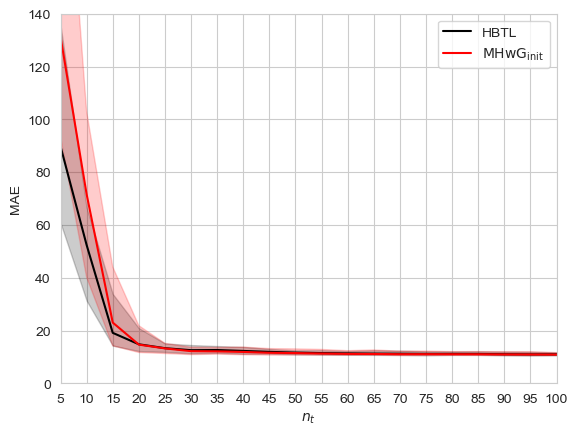

In [44]:
##################################################################### HBTL vs MHwG_init ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=HBTL_sim_results["train_size"], y=HBTL_sim_results["MAE_test"], color="black", label="HBTL")
sns.lineplot(x=MHwG_init_sim_results["train_size"], y=MHwG_init_sim_results["MAE_test"], color="red", label="$\mathrm{MHwG}_\mathrm{init}$")

plt.fill_between(HBTL_sim_results["train_size"], HBTL_sim_results["lower_ci_mae_test"], 
                 HBTL_sim_results["upper_ci_mae_test"], color="black", alpha=0.2)
plt.fill_between(MHwG_init_sim_results["train_size"], MHwG_init_sim_results["lower_ci_mae_test"], 
                 MHwG_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Sim_data_HBTL_vs_MHwG_init.pdf", bbox_inches="tight")
plt.show()

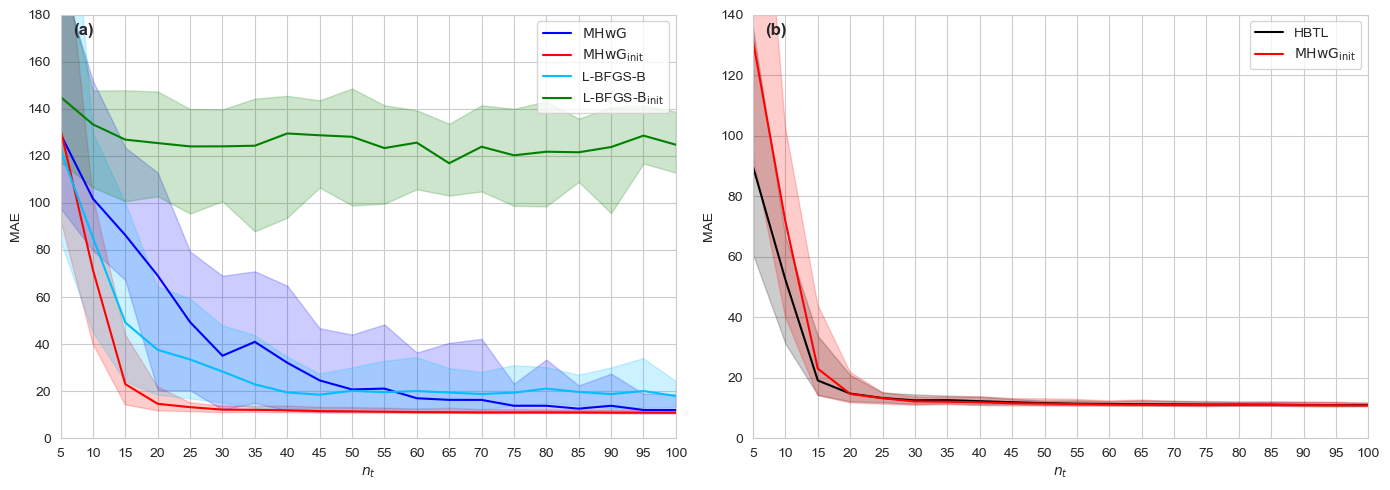

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Créer une figure avec 2 subplots côte à côte
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

##################################################################### 
# Panel (a) - Gauche: Competitors
#####################################################################
sns.set_style("whitegrid")
sns.lineplot(x=MHwG_sim_results["train_size"], y=MHwG_sim_results["MAE_test"], 
             color="blue", label="$\mathrm{MHwG}$", ax=ax1)
sns.lineplot(x=MHwG_init_sim_results["train_size"], y=MHwG_init_sim_results["MAE_test"], 
             color="red", label="$\mathrm{MHwG}_\mathrm{init}$", ax=ax1)
sns.lineplot(x=LBFGSB_sim_results["train_size"], y=LBFGSB_sim_results["MAE_test"], 
             color="deepskyblue", label="L-BFGS-B", ax=ax1)
sns.lineplot(x=LBFGSB_init_sim_results["train_size"], y=LBFGSB_init_sim_results["MAE_test"], 
             color="green", label="L-BFGS-$\mathrm{B}_\mathrm{init}$", ax=ax1)

ax1.fill_between(MHwG_sim_results["train_size"], MHwG_sim_results["lower_ci_mae_test"], 
                 MHwG_sim_results["upper_ci_mae_test"], color="blue", alpha=0.2)
ax1.fill_between(MHwG_init_sim_results["train_size"], MHwG_init_sim_results["lower_ci_mae_test"], 
                 MHwG_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)
ax1.fill_between(LBFGSB_sim_results["train_size"], LBFGSB_sim_results["lower_ci_mae_test"], 
                 LBFGSB_sim_results["upper_ci_mae_test"], color="deepskyblue", alpha=0.2)
ax1.fill_between(LBFGSB_init_sim_results["train_size"], LBFGSB_init_sim_results["lower_ci_mae_test"], 
                 LBFGSB_init_sim_results["upper_ci_mae_test"], color="green", alpha=0.2)

train_sizes = list(range(5, 105, 5))
ax1.set_xticks(train_sizes)
ax1.set_xlim(5, 100)  
ax1.set_ylim(0, 180) 
ax1.set_xlabel("$n_t$")
ax1.set_ylabel("MAE")
ax1.legend()
ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')

##################################################################### 
# Panel (b) - Droite: HBTL vs MHwG_init
#####################################################################
sns.lineplot(x=HBTL_sim_results["train_size"], y=HBTL_sim_results["MAE_test"], 
             color="black", label="HBTL", ax=ax2)
sns.lineplot(x=MHwG_init_sim_results["train_size"], y=MHwG_init_sim_results["MAE_test"], 
             color="red", label="$\mathrm{MHwG}_\mathrm{init}$", ax=ax2)

ax2.fill_between(HBTL_sim_results["train_size"], HBTL_sim_results["lower_ci_mae_test"], 
                 HBTL_sim_results["upper_ci_mae_test"], color="black", alpha=0.2)
ax2.fill_between(MHwG_init_sim_results["train_size"], MHwG_init_sim_results["lower_ci_mae_test"], 
                 MHwG_init_sim_results["upper_ci_mae_test"], color="red", alpha=0.2)

ax2.set_xticks(train_sizes)
ax2.set_xlim(5, 100)  
ax2.set_ylim(0, 140) 
ax2.set_xlabel("$n_t$")
ax2.set_ylabel("MAE")
ax2.legend()
ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Sauvegarder
plt.savefig("C:/Users/abedy/Downloads/HBTL_competitor_combined.pdf", bbox_inches="tight")
plt.show()

## Real data set

In [14]:
##################################################################### HBTL and its competitors ####################################################################################
HBTL_real_results = pd.read_csv("Final_results_csv_files/HBTL_real_results.csv")
MHwG_real_results = pd.read_csv("Final_results_csv_files/MHwG_real_results.csv")
MHwG_init_real_results = pd.read_csv("Final_results_csv_files/MHwG_init_real_results.csv")
LBFGSB_real_results = pd.read_csv("Final_results_csv_files/LBFGSB_real_results.csv")
LBFGSB_init_real_results = pd.read_csv("Final_results_csv_files/LBFGSB_init_real_results.csv")

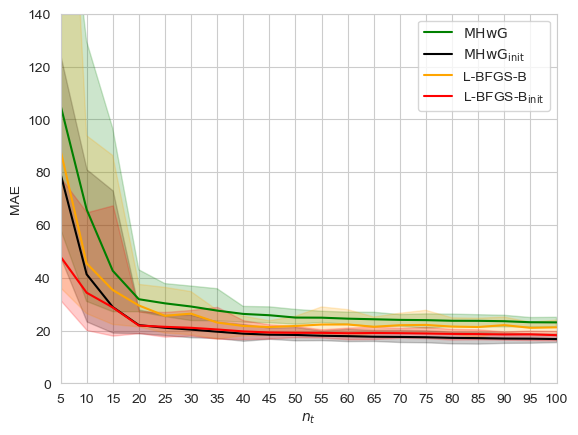

In [42]:
##################################################################### Competitors ################################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=MHwG_real_results["train_size"], y=MHwG_real_results["MAE_test"], color="green", label="$\mathrm{MHwG}$")
sns.lineplot(x=MHwG_init_real_results["train_size"], y=MHwG_init_real_results["MAE_test"], color="black", label="$\mathrm{MHwG}_\mathrm{init}$")
sns.lineplot(x=LBFGSB_real_results["train_size"], y=LBFGSB_real_results["MAE_test"], color="orange", label="L-BFGS-B")
sns.lineplot(x=LBFGSB_init_real_results["train_size"], y=LBFGSB_init_real_results["MAE_test"], color="red", label="L-BFGS-B$_\mathrm{init}$")


plt.fill_between(MHwG_real_results["train_size"], MHwG_real_results["lower_ci_mae_test"], 
                 MHwG_real_results["upper_ci_mae_test"], color="green", alpha=0.2)
plt.fill_between(MHwG_init_real_results["train_size"], MHwG_init_real_results["lower_ci_mae_test"], 
                 MHwG_init_real_results["upper_ci_mae_test"], color="black", alpha=0.2)
plt.fill_between(LBFGSB_real_results["train_size"], LBFGSB_real_results["lower_ci_mae_test"], 
                 LBFGSB_real_results["upper_ci_mae_test"], color="orange", alpha=0.2)
plt.fill_between(LBFGSB_init_real_results["train_size"], LBFGSB_init_real_results["lower_ci_mae_test"], 
                 LBFGSB_init_real_results["upper_ci_mae_test"], color="red", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 140) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Real_data_competitors_of_HBTL.pdf", bbox_inches="tight")
plt.show()

The best competitor $\mathrm{L\text{-}BFGS\text{-}B}_\mathrm{init}$ is then compared to HBTL.

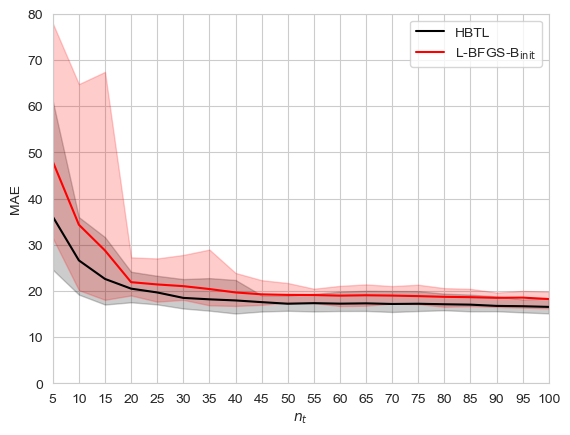

In [32]:
##################################################################### Compaetitors ####################################################################################
sns.set_style("whitegrid")
sns.lineplot(x=HBTL_real_results["train_size"], y=HBTL_real_results["MAE_test"], color="black", label="HBTL")
sns.lineplot(x=LBFGSB_init_real_results["train_size"], y=LBFGSB_init_real_results["MAE_test"], color="red", label="L-BFGS-B$_\mathrm{init}$")

plt.fill_between(HBTL_real_results["train_size"], HBTL_real_results["lower_ci_mae_test"], 
                 HBTL_real_results["upper_ci_mae_test"], color="black", alpha=0.2)
plt.fill_between(LBFGSB_init_real_results["train_size"], LBFGSB_init_real_results["lower_ci_mae_test"], 
                 LBFGSB_init_real_results["upper_ci_mae_test"], color="red", alpha=0.2)

train_sizes = list(range(5, 105, 5))
plt.xticks(train_sizes)
# ZOOM
plt.xlim(5, 100)  
plt.ylim(0, 80) 
plt.xlabel("$n_t$")
plt.ylabel("MAE")
plt.legend()
plt.savefig("Saved_figures/Real_data_competitors_of_HBTL.pdf", bbox_inches="tight")
plt.show()